#### [数据集说明]

##### 数据来源

[数据来源]()

##### 数据结构

见struct.jpg

#### 一、环境配置

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
# 修改imputer为SimpleImputer
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

import seaborn as sns
# from sklearn.metrics import roc_curve, auc, roc_auc_score

#### 二、数据信息配置

In [2]:
# 定义根路径
root = '/home/authorcai/PycharmProjects/FM智能检测矫正服/Data/UCI_HAR_Dataset/'

In [3]:
# 读取数据
features = pd.read_csv(root + 'features.txt', sep='\s+', index_col=0, header=None)
train_data = pd.read_csv(root + 'train/X_train.txt', sep='\s+', names=list(features.values.ravel()))
test_data = pd.read_csv(root + 'test/X_test.txt', sep='\s+', names=list(features.values.ravel()))
train_label = pd.read_csv(root + 'train/y_train.txt', sep='\s+', header=None)
test_label = pd.read_csv(root + 'test/y_test.txt', sep='\s+', header=None)
label_name = pd.read_csv(root + 'activity_labels.txt', sep='\s+', header=None)

# drop掉label_name自带的索引列
label_name = label_name.drop(columns=0,axis=1)

/usr/local/lib/python3.5/dist-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [4]:
# 标签信息查看
label_name

,1
0,WALKING
1,WALKING_UPSTAIRS
2,WALKING_DOWNSTAIRS
3,SITTING
4,STANDING
5,LAYING


In [5]:
# 处理label数据
def get_label_name(num):
    return label_name.iloc[num-1,0]#在原来的标签号基础上减一


In [6]:
train_data['label']=train_label
test_data['label']=test_label

In [7]:
# 匹配索引号和对应姿势名称
train_data['label_name']=train_data['label'].map(get_label_name)
test_data['label_name']=test_data['label'].map(get_label_name)

# 查看train_data是否匹配成功
pd.DataFrame(train_data['label_name'])['label_name'].value_counts()
# 查看test_data是否匹配成功
pd.DataFrame(test_data['label_name'])['label_name'].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: label_name, dtype: int64

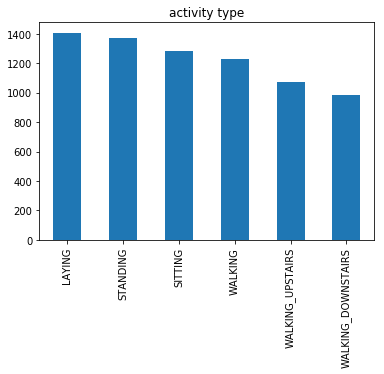

In [8]:
# 训练数据分类数量
train_data['label_name'].value_counts().plot(kind='bar', title='activity type')

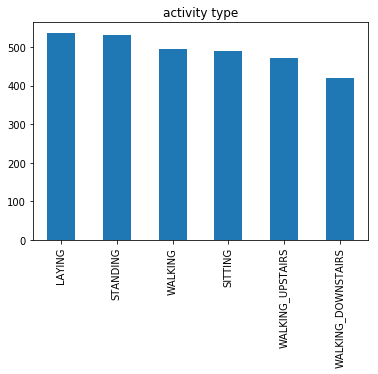

In [9]:
# 训练数据分类数量
test_data['label_name'].value_counts().plot(kind='bar', title='activity type')

##### （一）处理空值

In [10]:
# 将初始数据的空值用NaN替代
train_data.replace("?",np.NaN).head()
test_data.replace("?",np.NaN).head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",label,label_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,5,STANDING


##### （二）处理缺省值

In [11]:
# 无缺省，无需处理缺省值

##### （三）训练集和测试集信息说明

In [12]:
print("训练集样本模型:%d，特征属性：%d, 目标属性:%d " %(train_data.shape[0],train_data.shape[1],train_label.shape[1]))

训练集样本模型:7352，特征属性：563, 目标属性:1 


##### （四）根据算法要求处理数据  

In [13]:
#制作训练集和测试集，使格式符合sklean算法要求
x_train=train_data.iloc[:,:-2].values # 训练集X特征数据
x_test=train_data.iloc[:,-2].values # 训练集X标签数据
y_train=test_data.iloc[:,:-2].values # 测试集Y合特征数据
y_test=test_data.iloc[:,-2].values # 测试集Y标签数据


In [14]:
pd.DataFrame(y_test)[0].value_counts()

6    537
5    532
1    496
4    491
2    471
3    420
Name: 0, dtype: int64

In [15]:
# 查看处理后的数据信息
print(x_train.shape)
print(x_test.shape)

(7352, 561)
(7352,)


#### 三、对数据进行降维分析

##### （一）TSNE降维分析

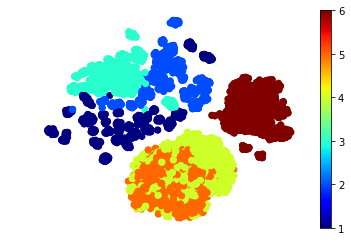

In [16]:
# 数据降维分析TSNE
#对数据进行降维可视化
#使用t-sne进行可视化分析
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)#调入t-sne(将数据降成二维)
out=tsne.fit_transform(x_train)#使用t-sne，处理数据
plt.scatter(out[:, 0], out[:, 1], c=x_test,cmap='jet')#画图
plt.axis('off')
plt.colorbar()
plt.show()

##### （二）PCA降维分析

In [17]:
# PCA降维
from sklearn.decomposition import PCA
pca = PCA(.99)#建立pca模型
X2D = pca.fit_transform(x_train)#使用pca，处理数据，训练并降维
radtio=pca.explained_variance_ratio_#画图，每个主成成分占方差比例
print(pca.n_components)#n_components指示主成成分有有的元素数量

0.99


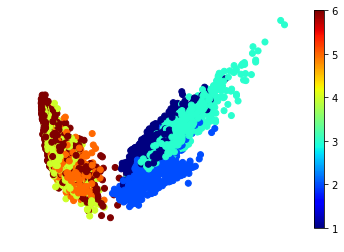

In [19]:
# PCA降维结果可视化
plt.scatter(X2D[:, 0], X2D[:, 1], c=x_test,cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

##### （三）降维结果总结

In [20]:
#pca降维，失去了结构信息;
#t-sne使属于流形学习，能将高维流形映射到低维空间，保留了结构;
#通过t-snef降维分析结果可知，使用该方法效果更加直观;
#从分析结果大致可以看出姿势3和姿势4,姿势5不好区分

#### 四、根据特征对数据进行分布分析

##### （一）定义特征分布分析函数

In [21]:
#对某一个特征观察分布，输入为特征列名称，输出为分布结果
def plot_feature(feature_name):#想分析哪个特征，就将特征名输入函数即可
    plt.figure(figsize=(10,5))
    plt.title("Sensor data distribution for all label")
    class_indexs=list(label_name.values.ravel())#得到所有类别
    for class_index in class_indexs:#根据类别，画出
        sns.distplot(train_data[train_data['label_name']==class_index][feature_name], label=class_index)
    plt.legend()#给图像加上图例
    plt.show()# plots the distribution of all the columns of both left and wright wrist

##### （二）依次分析特征

###### （1）特征一：tBodyAcc-mean()-X

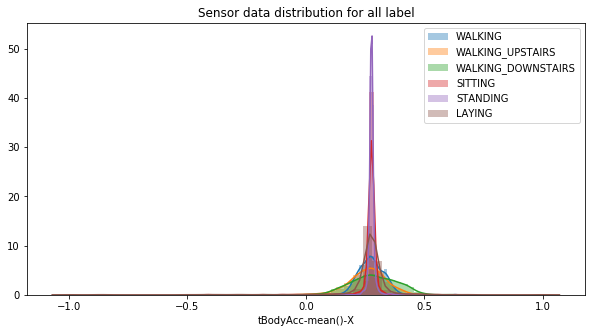

In [22]:
plot_feature('tBodyAcc-mean()-X')

###### （2）特征二：tBodyAcc-energy()-X

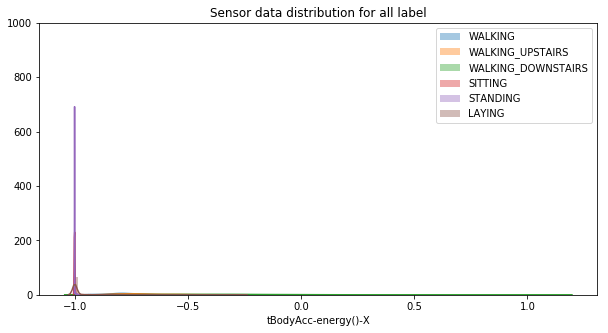

In [23]:
plot_feature('tBodyAcc-energy()-X')

###### （3）特征三：angle(X,gravityMean)

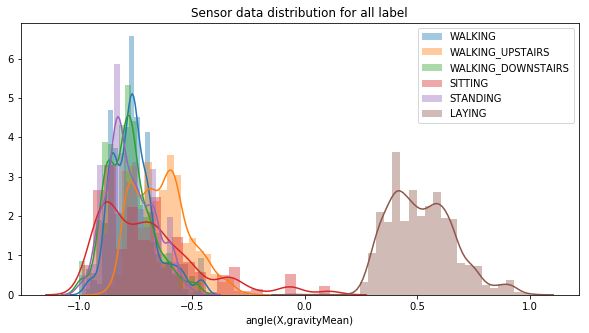

In [24]:
plot_feature('angle(X,gravityMean)')

#### 三、建立随机森林模型训练

##### （一）构建模型

In [25]:
from sklearn.ensemble import RandomForestClassifier
# 使用GridSeachCV自动调参，解决手动调参存在的种种问题
from sklearn.model_selection import GridSearchCV 
#对max_features和n_estimators进行选择
clf = RandomForestClassifier(max_features=None,random_state=0)
estimator=np.arange(20,160,40)
my_max_features = [ "sqrt", "log2"]
param_grid={'n_estimators':estimator,"max_features":my_max_features}
gs=GridSearchCV(estimator=clf,param_grid=param_grid,cv=10,verbose=4,n_jobs=-1)

##### （二）训练模型

In [26]:
gs.fit(x_train,x_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   59.0s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                    

##### （三）评估模型

In [27]:
# 通过best_score
best_score = gs.best_score_
best_param = gs.best_params_
best_estimator = gs.best_estimator_
print("(1)模型的准确率为：%.2f%%\n" %(best_score*100))

# 通过表格形式展示参数数据
print("(2)模型的最佳参数信息：")
dict = pd.DataFrame(pd.Series(best_param),columns=['value'])
dict

(1)模型的准确率为：93.84%

(2)模型的最佳参数信息：


,value
max_features,log2
n_estimators,140


##### （四）模型预测

###### （1）获取预测结果

In [28]:
# 通过predict获取模型预测结果
prediction = best_estimator.predict(y_train)
prediction_new = pd.DataFrame(prediction)
prediction_new.columns=['activity']

# 对预测结果数量进行统计
prediction_new['activity'].value_counts()
prediction_new

# 对预测结果标签进行数字替换，按names进行替换
names = {
    1:'WALKING',
    2:'WALKING_UPSTAIRS',
    3:'WALKING_DOWNSTAIRS',
    4:'SITTING',
    5:'STANDING',
    6:'LAYING'
}
prediction_new['activity']= prediction_new['activity'].map(names)
# prediction_new.loc[prediction_new['activity' == 1]] = names[1]
# prediction_new.loc[prediction_new['activity' == 2]] = names[2]
# prediction_new.loc[prediction_new['activity' == 3]] = names[3]
# prediction_new.loc[prediction_new['activity' == 4]] = names[4]
# prediction_new.loc[prediction_new['activity' == 5]] = names[5]
# prediction_new.loc[prediction_new['activity' == 6]] = names[6]

# 查看预测结果信息
prediction_new['activity'].describe()
prediction_new['activity'].value_counts()

STANDING              567
LAYING                537
WALKING               534
WALKING_UPSTAIRS      487
SITTING               455
WALKING_DOWNSTAIRS    367
Name: activity, dtype: int64

###### (2)处理预测结果

In [29]:
y_true = y_test

In [30]:
pd.DataFrame(prediction)[0].value_counts()

5    567
6    537
1    534
2    487
4    455
3    367
Name: 0, dtype: int64

In [31]:
pd.DataFrame(y_true)[0].value_counts()

6    537
5    532
1    496
4    491
2    471
3    420
Name: 0, dtype: int64

In [32]:
# 对prediciton 作-1处理
i = 0
for value in prediction:
    prediction[i]=value-1
    i = i+1
    
# 对y_test 作-1处理
i = 0
for value in y_test:
    y_true[i]=value-1
    i = i+1


In [33]:
pd.DataFrame(prediction)[0].value_counts()

4    567
5    537
0    534
1    487
3    455
2    367
Name: 0, dtype: int64

In [34]:
pd.DataFrame(y_true)[0].value_counts()

5    537
4    532
0    496
3    491
1    471
2    420
Name: 0, dtype: int64

In [35]:
prediction

array([4, 4, 4, ..., 1, 1, 0])

###### （2）预测结果可视化

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# 生成获取混淆矩阵
cm = confusion_matrix(y_true=y_true,y_pred=prediction)

In [37]:
# 查看混淆矩阵
cm

array([[484,   1,  11,   0,   0,   0],
       [ 28, 436,   7,   0,   0,   0],
       [ 22,  49, 349,   0,   0,   0],
       [  0,   1,   0, 440,  50,   0],
       [  0,   0,   0,  15, 517,   0],
       [  0,   0,   0,   0,   0, 537]])

In [38]:
# 混淆矩阵信息添加
columns = ['WALKING', 'WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
cm_df = pd.DataFrame(cm)
cm_df.columns = columns
cm_df.index = columns

# 展示混淆矩阵
cm_df

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,484,1,11,0,0,0
WALKING_UPSTAIRS,28,436,7,0,0,0
WALKING_DOWNSTAIRS,22,49,349,0,0,0
SITTING,0,1,0,440,50,0
STANDING,0,0,0,15,517,0
LAYING,0,0,0,0,0,537


Text(32.09374999999999, 0.5, 'true')

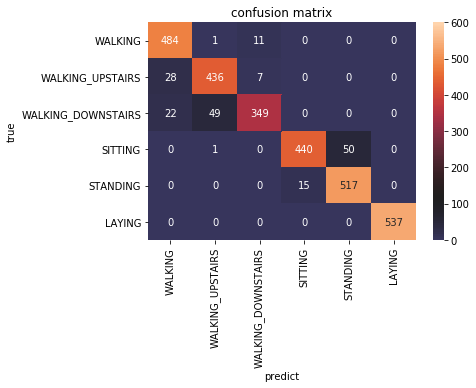

In [39]:
import seaborn as sns
#转换成dataframe，转不转一样
#fmt参数不使用科学计数法进行显示
ax = sns.heatmap(cm_df,annot=True,fmt='.20g',center=120,vmin=0,vmax=600)
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

#### 四、结果分析

##### （一）重要程度分析

##### （二）模型评价

* 使用随机森林模型可以有效地分辨静态姿势和动态姿势
* 在使用随机森林模型处理时，对静态姿势的分类存在缺陷（不足）
* 随机森林模型在辨别sitting 和 standing分类时，存在较大缺陷

#### 四、可结合其他机器学习方法

##### （一）使用线性模型处理

##### （二）尝试其他类型的分类器：SVM、梯度提升树等